# 1 Предобработка

### 1.1 Очистка и нормализация текста

In [1]:
import pandas as pd

data = pd.read_csv(
    r'data\raw_dataset.csv',
    encoding='latin-1',
    header=None,
    names=['target', 'id', 'date', 'flag', 'user', 'text']
)

data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<Axes: >

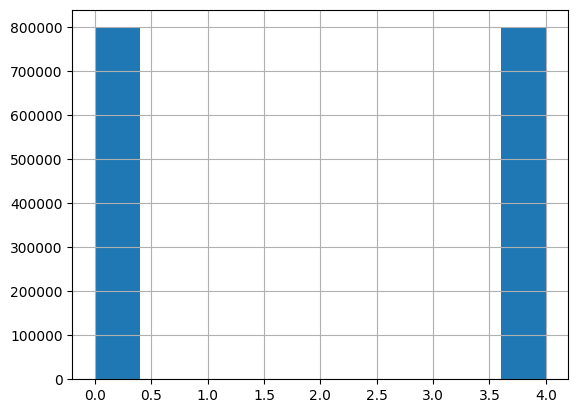

In [2]:
data['target'].hist()

В нижний регистр

In [3]:
text_lower = data['text'].str.lower()

text_lower

0          @switchfoot http://twitpic.com/2y1zl - awww, t...
1          is upset that he can't update his facebook by ...
2          @kenichan i dived many times for the ball. man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 1600000, dtype: object

Удаление ссылок итд + удаление дубликатов

In [4]:
import re

# ссылки и домены
URL_RE = re.compile(r'(https?://\S+|www\.\S+|[a-zA-Z0-9\-]+\.[a-zA-Z]{2,})')
# упоминания
MENTION_RE = re.compile(r'@\w+')
# хэштеги
HASHTAG_RE = re.compile(r'#\w+')

# оставить только латиницу/цифры/пробелы и пунктуацию . , '
ALLOWED_CHARS_RE = re.compile(r"[^a-z0-9\s\.\,']")

# схлопывание повторов:
# 1) буквы: 3+ одинаковых подряд -> 2 (cooool -> coool -> coo)
LETTER_RUNS_RE = re.compile(r'([a-z])\1{2,}')
# 2) пунктуация . , ' : 2+ -> 1 (.... -> .  ,, -> ,  ''' -> ')
PUNCT_RUNS_RE = re.compile(r"([\.\,'])\1+")

def clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()

    # убрать ссылки/упоминания/хэштеги
    text = URL_RE.sub(" ", text)
    text = MENTION_RE.sub(" ", text)
    text = HASHTAG_RE.sub(" ", text)

    # убрать все, кроме [a-z0-9] пробелов и . , '
    text = ALLOWED_CHARS_RE.sub(" ", text)

    # схлопнуть длинные буквы (оставить максимум две подряд)
    text = LETTER_RUNS_RE.sub(r"\1\1", text)

    # схлопнуть повторы пунктуации до одной
    text = PUNCT_RUNS_RE.sub(r"\1", text)

    # убрать лишние пробелы
    text = re.sub(r"\s+", " ", text).strip()
    return text



clean_text_lower = text_lower.apply(clean)
clean_text_lower = clean_text_lower.drop_duplicates().reset_index(drop=True)

clean_text_lower

0          aww, that's a bummer. you shoulda got david ca...
1          is upset that he can't update his facebook by ...
2          i dived many times for the ball. managed to sa...
3             my whole body feels itchy and like its on fire
4          no, it's not behaving at all. i'm mad. why am ...
                                 ...                        
1526945    yeah, that does work better than just waiting ...
1526946    just woke up. having no school is the best fee...
1526947                very cool to hear old walt interviews
1526948    are you ready for your mojo makeover ask me fo...
1526949    happy 38th birthday to my boo of all time tupa...
Name: text, Length: 1526950, dtype: object

Статистика

count    19904174.00
mean            4.09
std             2.15
min             1.00
25%             3.00
50%             4.00
75%             5.00
max           112.00
Name: word_len, dtype: float64


<Axes: >

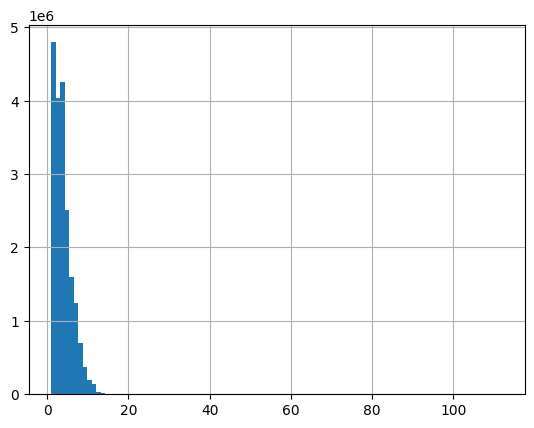

In [5]:
lengths = [len(w) for s in clean_text_lower for w in s.split()]


print(pd.Series(lengths, name="word_len").describe().round(2))
pd.Series(lengths, name="word_len").hist(bins = 100)

### 1.2 Токенизация

In [6]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token 

texts = clean_text_lower.astype(str).tolist()

enc = tokenizer(
    texts,
    truncation=True,
    padding=False,
    max_length=32,
    return_attention_mask=True,
    return_tensors=None
)

input_ids = [ids + [tokenizer.eos_token_id] for ids in enc["input_ids"]]
input_ids

c:\Users\USER\practicum_yandex_autocompletion\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1+cu118
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


[[707,
  86,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286,
  2368,
  1110,
  284,
  466,
  340,
  13,
  288,
  50256],
 [271,
  9247,
  326,
  339,
  460,
  470,
  4296,
  465,
  23960,
  416,
  36634,
  340,
  13,
  290,
  1244,
  3960,
  355,
  257,
  1255,
  1524,
  1909,
  635,
  13,
  33367,
  50256],
 [72,
  288,
  1572,
  867,
  1661,
  329,
  262,
  2613,
  13,
  5257,
  284,
  3613,
  2026,
  262,
  1334,
  467,
  503,
  286,
  22303,
  50256],
 [1820, 2187, 1767, 5300, 340, 29658, 290, 588, 663, 319, 2046, 50256],
 [3919,
  11,
  340,
  338,
  407,
  37722,
  379,
  477,
  13,
  1312,
  1101,
  8805,
  13,
  1521,
  716,
  1312,
  994,
  780,
  1312,
  460,
  470,
  766,
  345,
  477,
  625,
  612,
  13,
  50256],
 [1662, 262, 2187, 5462, 50256],
 [31227, 257, 16225, 50256],
 [20342,
  890,
  640,
  645,
  766,
  3763,
  13,
  29424,
  257,
  1643,
  837,
  8807,
  257,
  1643,
  19462,
  837,
  1312,
  1101,
  3734

### 1.3 Разделение на трейн, валидацию и тест

In [7]:
from sklearn.model_selection import train_test_split


data = pd.DataFrame({'text': texts, "input_ids": input_ids})

train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

In [8]:
import os


os.makedirs("data", exist_ok=True)

train_df.to_csv('data/train.csv', index = False)
val_df.to_csv('data/val.csv', index = False)
test_df.to_csv('data/test.csv', index = False)

## 2 Обучение модели

In [ ]:
import pandas as pd
import ast

data_train = pd.read_csv(r"data\train.csv")
data_train["input_ids"] = data_train["input_ids"].apply(ast.literal_eval)

data_val = pd.read_csv(r"data\val.csv")
data_val["input_ids"] = data_val["input_ids"].apply(ast.literal_eval)

import os
from tqdm import tqdm

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer

from src.dataset import NextTokenDataset
from src.model import RNNAutocompletion


EXP_NAME = "exp2"
TRAIN_MAX_LENGTH = 32
EPOCHS = 100
BATCH_SIZE = 4048
LR = 2e-3
DIM = 512
NUM_LAYERS = 2
DROPOUT = 0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
pad_token_id = tokenizer.pad_token_id
vocab_size = tokenizer.vocab_size

dataset_train = NextTokenDataset(data_train, pad_token=pad_token_id, max_length=TRAIN_MAX_LENGTH)
dataset_val = NextTokenDataset(data_val, pad_token=pad_token_id, max_length=TRAIN_MAX_LENGTH)

dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
dl_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model = RNNAutocompletion(
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    dim=DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-5
)

save_path = os.path.join("exp", EXP_NAME)
os.makedirs(f"{save_path}/weights", exist_ok=True)
writer = SummaryWriter(log_dir=f"{save_path}/logs")

best_val_loss = float("inf")
train_step = 0

for epoch in range(EPOCHS):

    model.eval()
    val_losses = []
    val_correct = 0
    val_correct_top5 = 0
    val_total = 0

    with torch.no_grad(), torch.cuda.amp.autocast():
        for batch in tqdm(dl_val, desc=f"Epoch {epoch} valid", unit="batch"):
            input_ids = batch["input_ids"].to(device)
            lengths = batch["length"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, lengths)
            loss = criterion(logits, labels)
            val_losses.append(loss.item())

            preds = logits.argmax(dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.numel()

            _, top5 = logits.topk(5, dim=-1)
            val_correct_top5 += (top5 == labels.unsqueeze(-1)).any(dim=-1).sum().item()

    val_loss = np.mean(val_losses)
    val_ppl = np.exp(val_loss)
    val_acc = val_correct / val_total
    val_acc_top5 = val_correct_top5 / val_total

    print(f"epoch {epoch} valid loss: {val_loss:.4f} | ppl: {val_ppl:.2f} "f"| acc@1: {val_acc:.4f} | acc@5: {val_acc_top5:.4f}")
    writer.add_scalar("Loss/valid", val_loss, epoch)
    writer.add_scalar("Perplexity/valid", val_ppl, epoch)
    writer.add_scalar("Acc/valid",  val_acc,  epoch)
    writer.add_scalar("Acc/valid_top5", val_acc_top5, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"{save_path}/weights/best.pt")

    model.train()
    train_losses = []

    for batch in tqdm(dl_train, desc=f"Epoch {epoch} train", unit="batch"):
        input_ids = batch["input_ids"].to(device)
        lengths = batch["length"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(input_ids, lengths)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)                                
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        scaler.step(optimizer)                                    
        scaler.update()

        train_losses.append(loss.item())
        writer.add_scalar("Loss/train_step", loss.item(), train_step)
        scheduler.step()
        train_step += 1

    train_loss = np.mean(train_losses)
    print(f"epoch {epoch} train loss: {train_loss:.4f}")
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("LR", scheduler.get_last_lr()[0], train_step)


torch.save(model.state_dict(), f"{save_path}/weights/last.pt")
writer.close()

cuda


Epoch 0 valid: 100%|██████████| 610/610 [00:26<00:00, 22.81batch/s]


epoch 0 valid loss: 96.5374 | ppl: 842701104516663743513347104890681412288512.00 | acc@1: 0.0000 | acc@5: 0.0001


Epoch 0 train:  41%|████      | 1979/4880 [03:25<04:19, 11.18batch/s]

In [34]:
import pandas as pd
import ast


data_test = pd.read_csv(r"data\test.csv")
data_test["input_ids"] = data_test["input_ids"].apply(ast.literal_eval)

import torch
from transformers import AutoTokenizer
from src.model import RNNAutocompletion
import evaluate

dataset_test = NextTokenDataset(data_test, pad_token=pad_token_id, max_length=TRAIN_MAX_LENGTH)

dl_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model.eval()
test_losses = []
test_correct = 0
test_correct_top5 = 0
test_total = 0

with torch.no_grad(), torch.cuda.amp.autocast():
    for batch in tqdm(dl_test, desc=f"Epoch {epoch} valid", unit="batch"):
        input_ids = batch["input_ids"].to(device)
        lengths = batch["length"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, lengths)
        loss = criterion(logits, labels)
        test_losses.append(loss.item())

        preds = logits.argmax(dim=-1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.numel()

        _, top5 = logits.topk(5, dim=-1)
        test_correct_top5 += (top5 == labels.unsqueeze(-1)).any(dim=-1).sum().item()

test_loss = np.mean(test_losses)
test_ppl = np.exp(test_loss)
test_acc = test_correct / test_total
test_acc_top5 = test_correct_top5 / test_total

print(f"Test loss: {test_loss:.4f} | ppl: {test_ppl:.2f} "f"| acc@1: {test_acc:.4f} | acc@5: {test_acc_top5:.4f}")

Epoch 29 valid: 100%|██████████| 305/305 [00:18<00:00, 16.66batch/s]

Test loss: 4.4561 | ppl: 86.15 | acc@1: 0.2419 | acc@5: 0.4600


In [ ]:
DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.3

tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
pad_token_id = tokenizer.pad_token_id
vocab_size = tokenizer.vocab_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNNAutocompletion(
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    dim=DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

checkpoint = torch.load("exp/exp2/weights/best.pt", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

rouge = evaluate.load("rouge")

batch_size = 16
context_lengths = [1, 3, 9]
max_gen_tokens = 32

for n in context_lengths:
    print(f"\n==== Context length: {n} ====")
    
    all_predictions = []
    all_references = []

    for i in range(0, len(data_test.input_ids), batch_size):
        batch_messages = data_test.input_ids[i : i + batch_size]

        contexts = [msg[:n] for msg in batch_messages]
        contexts = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(c, dtype=torch.long) for c in contexts],
            batch_first=True,
            padding_value=pad_token_id
        ).to(device)

        references = [msg[n:] for msg in batch_messages]

        with torch.no_grad():
            generated_batch = model.generate(start_tokens=contexts, max_tokens=max_gen_tokens)

        for gen_tokens, ref in zip(generated_batch, references):
            pred_text = tokenizer.decode(gen_tokens.tolist(), skip_special_tokens=True)
            ref_text = tokenizer.decode(ref, skip_special_tokens=True)

            all_predictions.append(pred_text)
            all_references.append(ref_text)

    results = rouge.compute(predictions=all_predictions, references=all_references)
    print(f"ROUGE scores for context={n}: {results}")

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
c:\Users\USER\practicum_yandex_autocompletion\.venv\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\USER\practicum_yandex_autocompletion\.venv\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints an


==== Context length: 1 ====
ROUGE scores for context=1: {'rouge1': 0.09877197273403206, 'rouge2': 0.016250607197031308, 'rougeL': 0.09533003489961135, 'rougeLsum': 0.09530618615010411}

==== Context length: 3 ====
ROUGE scores for context=3: {'rouge1': 0.09082375690655733, 'rouge2': 0.013998795380578737, 'rougeL': 0.08784731491765635, 'rougeLsum': 0.08784631137917209}

==== Context length: 9 ====
ROUGE scores for context=9: {'rouge1': 0.062449731940425135, 'rouge2': 0.008703507178498496, 'rougeL': 0.06134786903299401, 'rougeLsum': 0.06133838792404446}
